In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.quantization
from tqdm import tqdm 
from torch.nn.utils import prune
# import hls4ml

In [66]:
from matplotlib import font_manager
from cycler import cycler
from matplotlib.font_manager import FontProperties
font_path = '/vols/cms/hw423/Acc/Fonts/ImperialSansText-Regular.ttf'
font_manager.fontManager.addfont(font_path)  # 添加字体路径
font_name = font_manager.FontProperties(fname=font_path).get_name()  # 获取字体名称
plt.rcParams['font.family'] = font_name 
plt.rcParams['axes.prop_cycle'] = cycler(color=['#0000CD', '#7B68EE', '#000080', '#C71585', '#9467bd'])
plt.rcParams['figure.facecolor'] ='#F5F5F5'
plt.rcParams['axes.facecolor'] = '#F5F5F5'

In [48]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

# Original Model

In [49]:
batch = 1024
num_epochs = 40
layers = [64,32,16]
lr = 0.0005
df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2],1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

# class BinaryClassificationModel(nn.Module):
#     def __init__(self,n_features =X.shape[1],nodes=layers,output_nodes = 1):
#         super(BinaryClassificationModel, self).__init__()
#         n_nodes = [n_features] + nodes + [output_nodes]
#         self.layers = nn.ModuleList()
#         for i in range(len(n_nodes)-1):
#             self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
#             self.layers.append(nn.ReLU())

#     def forward(self, x):
#         out = self.layers[0](x)
#         for layer in self.layers[1:]:
#             out = layer(out)
#         return torch.sigmoid(out)

In [50]:
model = BinaryClassificationModel()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
stt = time.time()
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        t.set_postfix(train_loss=loss.item())

100%|██████████| 40/40 [04:00<00:00,  6.00s/it, train_loss=0.205]


In [55]:

model.eval()
y_pre = []
T = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs = model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.9158333333333334
Predict time: 0.44039154052734375


In [1]:
plt.hist(T,bins=20)
# plt.xlim(0,)

NameError: name 'plt' is not defined

In [57]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc0 = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc0}')

AUC = 0.964279071572193


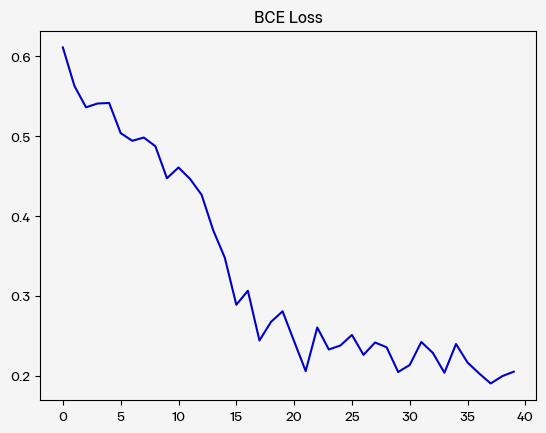

In [67]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losses)):
    lss.append(losses[i].detach())
plt.plot(lss)
plt.title('BCE Loss')
plt.savefig('Loss.pdf')

# Post-Pruning

In [20]:
for module in model.modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.3)
for module in model.modules():
    if isinstance(module, torch.nn.Linear):
        prune.remove(module, 'weight')

# Post Quantisation

In [59]:
model.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model,  
    {nn.Linear},  
    dtype=torch.float16
)
quantized_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = quantized_model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy1 = correct / total

In [60]:
model.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model,  
    {nn.Linear},  
    dtype=torch.qint8
)
quantized_model.eval()
QT = []
for _ in range(200):
    correct = 0
    total = 0
    Qtimes = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            stt = time.time()
            outputs = quantized_model(inputs)
            ent = time.time()
            Qtimes+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    QT.append(Qtimes)
QT=np.array(QT)
accuracy2 = correct / total
print(f'Accuracy = {accuracy2}')
print(f'Predict time: {Qtimes}')

Accuracy = 0.9063333333333333
Predict time: 0.007819890975952148


In [61]:
AUC(model,test_loader)

AUC = 0.964279071572193


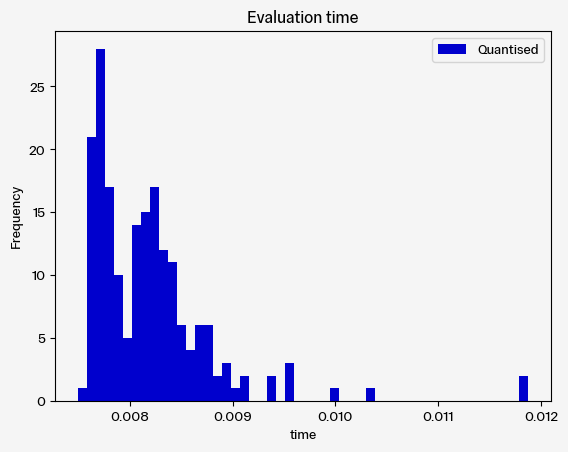

In [75]:
a,b,_= plt.hist(QT[QT<0.05],bins=50,density =False,label = 'Quantised')
# plt.hist(T,bins=b,density = False, label = 'Unquantised')
# plt.xlim(0.006,0.05)
# plt.xscale('log')
plt.title('Evaluation time')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('vt.pdf')

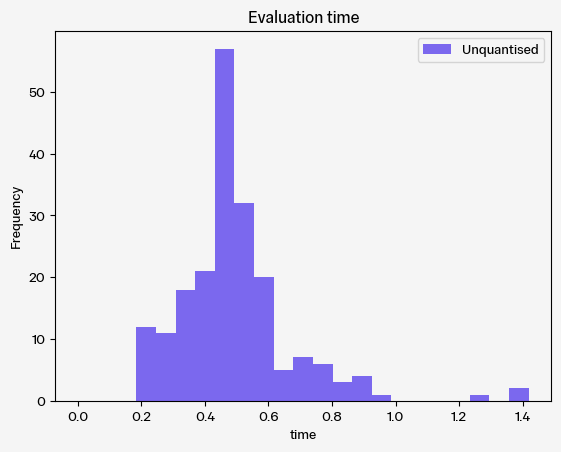

In [76]:
plt.hist([],bins=100,density =False)
plt.hist(T,bins=20,density = False, label = 'Unquantised')
# plt.xlim(0,0.2)
# plt.xscale('log')
plt.title('Evaluation time')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('time')
plt.savefig('vt_u.pdf')

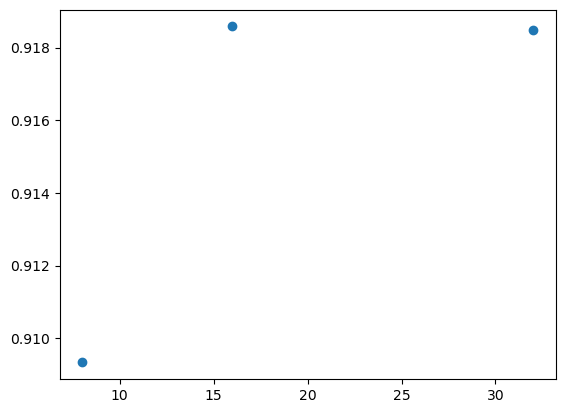

In [49]:
plt.scatter([8,16,32],[accuracy2,accuracy1,accuracy0])

In [77]:
import os
def model_size(model, label=' '):
    torch.save(model.state_dict(),"/vols/cms/hw423/Acc/mymodel.p")
    size = os.path.getsize("/vols/cms/hw423/Acc/mymodel.p")
    print("model:",label,'\t','Size(KB):',size/1e3)
    os.remove("/vols/cms/hw423/Acc/mymodel.p")
    return size
# compare the size
f = model_size(model, "fp32")
q= model_size(quantized_model, "int8")
print("{0:.2f} smaller".format(f/q))

model: fp32 	 Size(KB): 48.911
model: int8 	 Size(KB): 17.077
2.86 smaller


In [78]:
quantized_model

BinaryClassificationModel(
  (layer0): DynamicQuantizedLinear(in_features=140, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer1): DynamicQuantizedLinear(in_features=64, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer2): DynamicQuantizedLinear(in_features=32, out_features=16, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer3): DynamicQuantizedLinear(in_features=16, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (sigmoid): Sigmoid()
)

# Quantisation-Aware 

In [8]:
batch = 1024
num_epochs = 20
layers = [128,32,16]
lr = 0.001
df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


class BinaryClassificationModelQ(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(num_features, layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = torch.relu(self.layer0(x))
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.sigmoid(self.layer2(x))
        x = self.dequant(x)
        return x
    
modelQ = BinaryClassificationModelQ(X.shape[1])
modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)

def Quantrain(model):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    # for layer, name in parameters_to_prune:
    #     prune.l1_unstructured(layer, name=name, amount=pruning_amount)
    with tqdm(range(num_epochs)) as t:
        for epoch in t:
            for inputs, labels in train_loader:
                outputs= model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses.append(loss)
            t.set_postfix(train_loss=loss.item())

    return losses, model

def Acc(model):
    model.eval()
    model = torch.quantization.convert(model, inplace=True)
    y_pre = []

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
            
    accuracy = correct / total
    return accuracy


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=512, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_en

/vols/cms/hw423/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [6]:
losess, modelQ = Quantrain(modelQ)

 35%|███▌      | 7/20 [02:36<04:51, 22.42s/it, back_time=0.271, fc_time=0.146, quant_time=0.000614, totaltime=0.419, train_loss=2.2] 


KeyboardInterrupt: 

In [ ]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs,_,_ = modelQ(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')